In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

In [2]:
ConsumptionSmoothing = namedtuple("ConsumptionSmoothing", 
                        ["R", "g1", "g2", "β_seq", "T"])

def creat_cs_model(R=1.05, g1=1, g2=1/2, T=65):
    β = 1/R
    β_seq = np.array([β**i for i in range(T+1)])
    return ConsumptionSmoothing(R=1.05, g1=1, g2=1/2, 
                                β_seq=β_seq, T=65)

In [3]:
def compute_optimal(model, a0, y_seq):
    R, T = model.R, model.T

    # non-financial wealth
    h0 = model.β_seq @ y_seq     # since β = 1/R

    # c0
    c0 = (1 - 1/R) / (1 - (1/R)**(T+1)) * (a0 + h0)
    c_seq = c0*np.ones(T+1)

    # verify
    A = np.diag(-R*np.ones(T), k=-1) + np.eye(T+1)
    b = y_seq - c_seq
    b[0] = b[0] + a0

    a_seq = np.linalg.inv(A) @ b
    a_seq = np.concatenate([[a0], a_seq])

    return c_seq, a_seq

In [4]:
# Financial wealth
a0 = -2     # such as "student debt"

# non-financial Income process
y_seq = np.concatenate([np.ones(46), np.zeros(20)])

cs_model = creat_cs_model()
c_seq, a_seq = compute_optimal(cs_model, a0, y_seq)

print('check a_T+1=0:', 
      np.abs(a_seq[-1] - 0) <= 1e-8)

check a_T+1=0: True


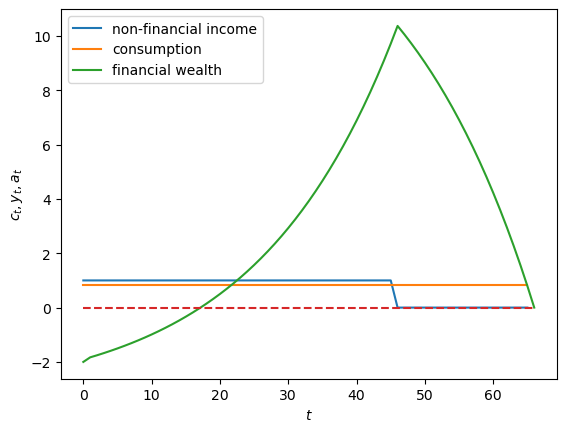

In [5]:
# Sequence Length
T = cs_model.T

plt.plot(range(T+1), y_seq, label='non-financial income')
plt.plot(range(T+1), c_seq, label='consumption')
plt.plot(range(T+2), a_seq, label='financial wealth')
plt.plot(range(T+2), np.zeros(T+2), '--')

plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$c_t,y_t,a_t$')
plt.show()

In [6]:
def welfare(model, c_seq):
    β_seq, g1, g2 = model.β_seq, model.g1, model.g2

    u_seq = g1 * c_seq - g2/2 * c_seq**2
    return β_seq @ u_seq

print('Welfare:', welfare(cs_model, c_seq))

Welfare: 13.285050962183442


In [7]:
def compute_variation(model, ξ1, ϕ, a0, y_seq, verbose=1):
    R, T, β_seq = model.R, model.T, model.β_seq

    ξ0 = ξ1*((1 - 1/R) / (1 - (1/R)**(T+1))) * ((1 - (ϕ/R)**(T+1)) / (1 - ϕ/R))
    v_seq = np.array([(ξ1*ϕ**t - ξ0) for t in range(T+1)])
    
    if verbose == 1:
        print('check feasible:', np.isclose(β_seq @ v_seq, 0))     # since β = 1/R

    c_opt, _ = compute_optimal(model, a0, y_seq)
    cvar_seq = c_opt + v_seq

    return cvar_seq

variation 0: ξ1=0.01, ϕ=0.95
check feasible: True
welfare=13.28500934606484
----------------------------------------------------------------
variation 1: ξ1=0.01, ϕ=1.02
check feasible: True
welfare=13.284911631015444
----------------------------------------------------------------
variation 2: ξ1=0.05, ϕ=0.95
check feasible: True
welfare=13.284010559218514
----------------------------------------------------------------
variation 3: ξ1=0.05, ϕ=1.02
check feasible: True
welfare=13.28156768298361
----------------------------------------------------------------


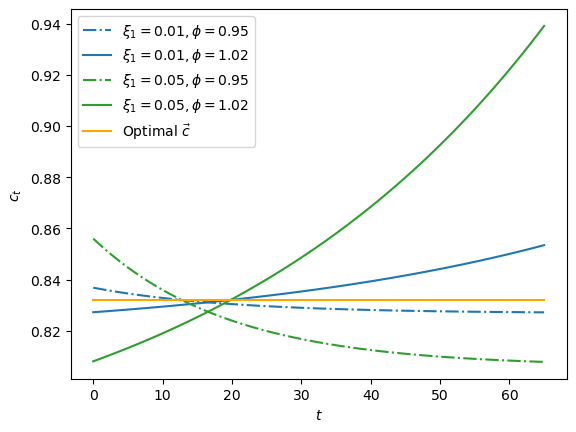

In [8]:
fig, ax = plt.subplots()

ξ1s = [.01, .05]
ϕs= [.95, 1.02]
colors = {.01: 'tab:blue', .05: 'tab:green'}

params = np.array(np.meshgrid(ξ1s, ϕs)).T.reshape(-1, 2)

for i, param in enumerate(params):
    ξ1, ϕ = param
    print(f'variation {i}: ξ1={ξ1}, ϕ={ϕ}')
    cvar_seq = compute_variation(model=cs_model, 
                                 ξ1=ξ1, ϕ=ϕ, a0=a0, 
                                 y_seq=y_seq)
    print(f'welfare={welfare(cs_model, cvar_seq)}')
    print('-'*64)
    if i % 2 == 0:
        ls = '-.'
    else: 
        ls = '-'  
    ax.plot(range(T+1), cvar_seq, ls=ls, 
            color=colors[ξ1], 
            label=fr'$\xi_1 = {ξ1}, \phi = {ϕ}$')

plt.plot(range(T+1), c_seq, 
         color='orange', label=r'Optimal $\vec{c}$ ')

plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$c_t$')
plt.show()

In [9]:
def welfare_rel(ξ1, ϕ):
    """
    Compute welfare of variation sequence 
    for given ϕ, ξ1 with a consumption smoothing model
    """
    
    cvar_seq = compute_variation(cs_model, ξ1=ξ1, 
                                 ϕ=ϕ, a0=a0, 
                                 y_seq=y_seq, 
                                 verbose=0)
    return welfare(cs_model, cvar_seq)

# Vectorize the function to allow array input
welfare_vec = np.vectorize(welfare_rel)

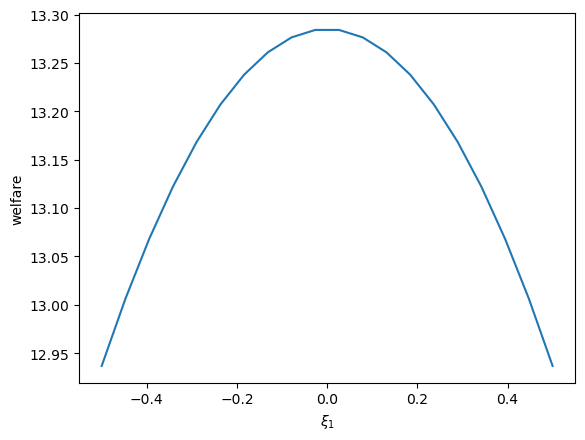

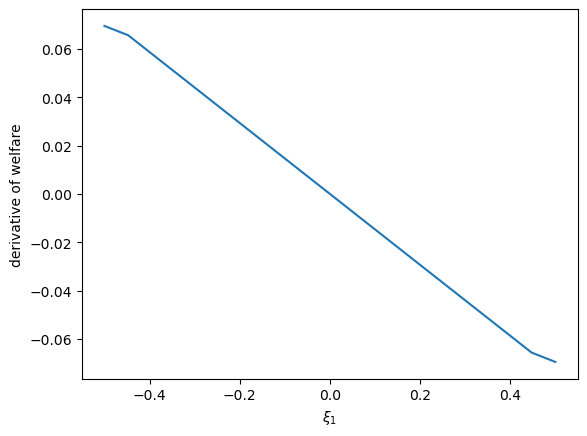

In [10]:
ξ1_arr = np.linspace(-0.5, 0.5, 20)

plt.plot(ξ1_arr, welfare_vec(ξ1_arr, 1.02))
plt.ylabel('welfare')
plt.xlabel(r'$\xi_1$')
plt.show()

welfare_grad = welfare_vec(ξ1_arr, 1.02)
welfare_grad = np.gradient(welfare_grad)
plt.plot(ξ1_arr, welfare_grad)
plt.ylabel('derivative of welfare')
plt.xlabel(r'$\xi_1$')
plt.show()

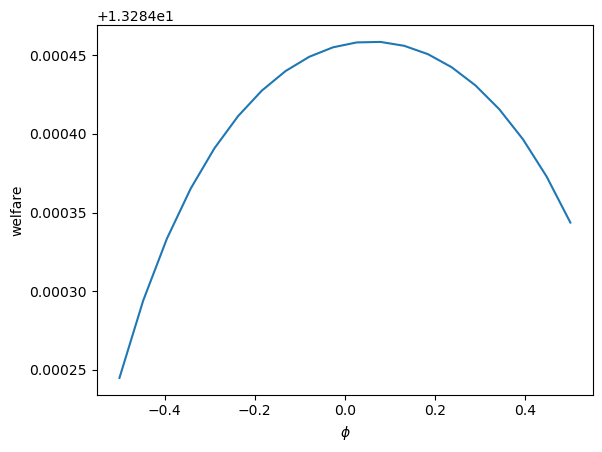

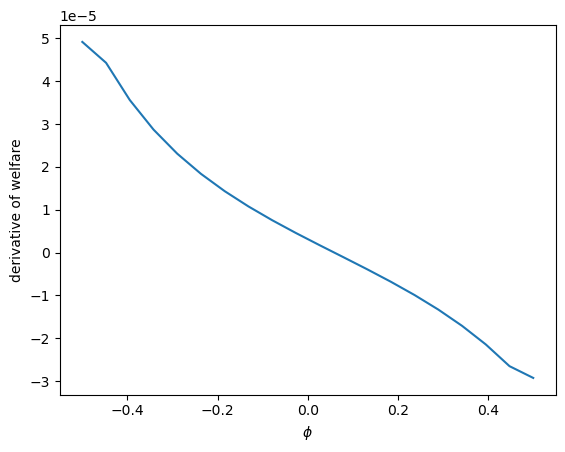

In [11]:
ϕ_arr = np.linspace(-0.5, 0.5, 20)

plt.plot(ξ1_arr, welfare_vec(0.05, ϕ_arr))
plt.ylabel('welfare')
plt.xlabel(r'$\phi$')
plt.show()

welfare_grad = welfare_vec(0.05, ϕ_arr)
welfare_grad = np.gradient(welfare_grad)
plt.plot(ξ1_arr, welfare_grad)
plt.ylabel('derivative of welfare')
plt.xlabel(r'$\phi$')
plt.show()